In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.potential import (
    LJ,
    DE,
)
from ff_energy.ffe.ff import FF
from ff_energy.ffe.constants import FFEPATH, PDB_PATH
from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot, residuals_from_keys
from ff_energy.logs.logging import hide_logs
from ff_energy.ffe.potential import LJ, LJ_bound, DE

hide_logs()
import scienceplots
set_style(no_latex=True)

from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json
from ff_energy.ffe.structure import atom_key_pairs

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, \
    PKL_PATH, get_structures

from sklearn.metrics import mean_squared_error as calc_rmse


0 ('C', 'C')
1 ('C', 'CG331')
2 ('C', 'CL')
3 ('C', 'CLA')
4 ('C', 'H')
5 ('C', 'HGA3')
6 ('C', 'HGP1')
7 ('C', 'HT')
8 ('C', 'OG311')
9 ('C', 'OT')
10 ('C', 'POT')
11 ('CG331', 'CG331')
12 ('CG331', 'CL')
13 ('CG331', 'CLA')
14 ('CG331', 'H')
15 ('CG331', 'HGA3')
16 ('CG331', 'HGP1')
17 ('CG331', 'HT')
18 ('CG331', 'OG311')
19 ('CG331', 'OT')
20 ('CG331', 'POT')
21 ('CL', 'CL')
22 ('CL', 'CLA')
23 ('CL', 'H')
24 ('CL', 'HGA3')
25 ('CL', 'HGP1')
26 ('CL', 'HT')
27 ('CL', 'OG311')
28 ('CL', 'OT')
29 ('CL', 'POT')
30 ('CLA', 'CLA')
31 ('CLA', 'H')
32 ('CLA', 'HGA3')
33 ('CLA', 'HGP1')
34 ('CLA', 'HT')
35 ('CLA', 'OG311')
36 ('CLA', 'OT')
37 ('CLA', 'POT')
38 ('H', 'H')
39 ('H', 'HGA3')
40 ('H', 'HGP1')
41 ('H', 'HT')
42 ('H', 'OG311')
43 ('H', 'OT')
44 ('H', 'POT')
45 ('HGA3', 'HGA3')
46 ('HGA3', 'HGP1')
47 ('HGA3', 'HT')
48 ('HGA3', 'OG311')
49 ('HGA3', 'OT')
50 ('HGA3', 'POT')
51 ('HGP1', 'HGP1')
52 ('HGP1', 'HT')
53 ('HGP1', 'OG311')
54 ('HGP1', 'OT')
55 ('HGP1', 'POT')
56 ('HT', 'HT'

<Figure size 100x100 with 0 Axes>

# Mike's data

In [2]:
EPOL = pd.read_csv("mikedata/epol.dat", sep=" ", header=None)
EPOL["KEY"] = EPOL[0].apply(lambda x: f"test{x}")
EPOL.index = EPOL.KEY
EPOL["EPOL"] = EPOL[1]
EPOL

,0,1,KEY,EPOL
KEY,,,,
test0,0,-12.842979,test0,-12.842979
test1,1,-12.893629,test1,-12.893629
test2,2,-10.587563,test2,-10.587563
test3,3,-9.974705,test3,-9.974705
test4,4,-19.145629,test4,-19.145629
...,...,...,...,...
test495,495,-12.622225,test495,-12.622225
test496,496,-11.377266,test496,-11.377266
test497,497,-12.797393,test497,-12.797393


In [3]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_mdcm.pkl")

In [4]:
data_ = data.data
data_.index = data_.KEY

In [5]:
data_ = data_.join(EPOL[["EPOL"]])
data_["ELECppol"] = data_["ELEC"] + data_["EPOL"]

In [6]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,EPOL,ELECppol
KEY,,,,,,,,,,,
test467,10.20492,-117.64677,27.55810,test467,-1527.187866,20,-1527.328541,-88.274060,-958403.241564,-13.997233,-131.644003
test263,10.99831,-117.58754,29.22768,test263,-1527.183081,20,-1527.326127,-89.762384,-958401.726960,-16.226241,-133.813781
test35,11.14697,-106.83781,32.02998,test35,-1527.185703,20,-1527.300030,-71.740517,-958385.350512,-14.940271,-121.778081
test223,10.64546,-106.00900,29.97665,test223,-1527.186209,20,-1527.289994,-65.125035,-958379.052942,-11.214738,-117.223738
test254,10.95917,-101.29607,16.86211,test254,-1527.186066,20,-1527.331554,-91.293912,-958405.132180,-11.906108,-113.202178
...,...,...,...,...,...,...,...,...,...,...,...
test100,12.11453,-101.28991,22.40034,test100,-1527.183347,20,-1527.307506,-77.910277,-958390.041931,-13.341739,-114.631649
test304,11.10241,-121.80230,32.56187,test304,-1527.190149,20,-1527.335938,-91.482928,-958407.882889,-16.469006,-138.271306
test327,11.10817,-85.53101,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595,-8.590109,-94.121119


In [7]:
structure = "water_redo"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 500 500


In [8]:
data_.sort_values("intE")

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,EPOL,ELECppol
KEY,,,,,,,,,,,
test76,11.21111,-89.36005,11.86175,test76,-1450.824462,19,-1527.317213,-47999.431132,-958396.133272,-11.009809,-100.369859
test4,10.54938,-142.01536,27.26727,test4,-1527.185213,20,-1527.382846,-124.015319,-958437.318158,-19.145629,-161.160989
test397,9.98637,-125.40988,18.62454,test397,-1527.183434,20,-1527.373442,-119.230703,-958431.417007,-17.109367,-142.519247
test67,9.74201,-132.42521,23.40678,test67,-1527.186353,20,-1527.375924,-118.956698,-958432.974463,-18.410357,-150.835567
test151,9.41990,-134.76793,25.87094,test151,-1527.186545,20,-1527.372006,-116.377171,-958430.516032,-15.917577,-150.685507
...,...,...,...,...,...,...,...,...,...,...,...
test365,12.44999,-82.64828,15.50390,test365,-1527.183359,20,-1527.276873,-58.680177,-958370.819613,-8.073924,-90.722204
test327,11.10817,-85.53101,19.52537,test327,-1527.185234,20,-1527.278286,-58.390447,-958371.706595,-8.590109,-94.121119
test177,11.26304,-74.80186,11.94163,test177,-1527.184798,20,-1527.275996,-57.226912,-958370.269331,-7.511043,-82.312903


In [9]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

array([[<AxesSubplot:title={'center':'TOTAL'}>,
        <AxesSubplot:title={'center':'ELEC'}>,
        <AxesSubplot:title={'center':'VDW'}>],
       [<AxesSubplot:title={'center':'M_ENERGY'}>,
        <AxesSubplot:title={'center':'n_monomers'}>,
        <AxesSubplot:title={'center':'C_ENERGY'}>],
       [<AxesSubplot:title={'center':'intE'}>,
        <AxesSubplot:title={'center':'C_ENERGY_kcalmol'}>,
        <AxesSubplot:title={'center':'EPOL'}>],
       [<AxesSubplot:title={'center':'ELECppol'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

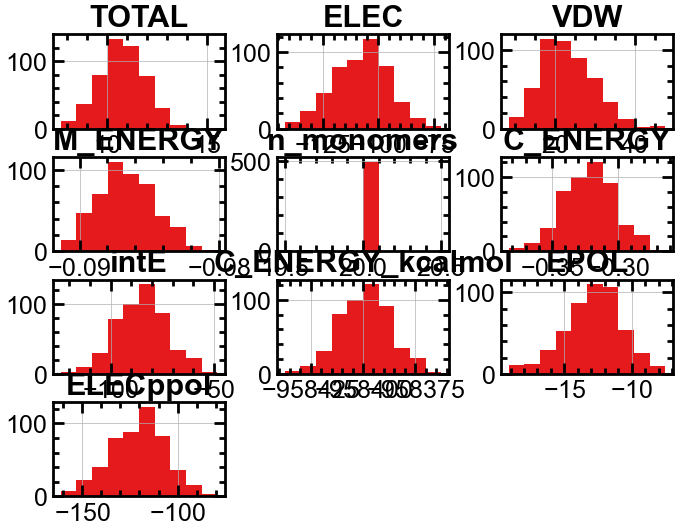

In [10]:
# dists.keys()
data_.sort_values("intE")[1:].hist()

In [11]:
ljpcff = FF(
    data_.sort_values("intE")[1:], # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec="ELECppol",
    intE=target,
)
#  set the targets
ljpcff.num_segments = len(ljpcff.data)
print("Nsegments", ljpcff.num_segments)
ljpcff.set_targets()

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0      -87.133554
test1      -76.513047
test10     -79.349417
test100    -77.910277
test101   -105.550755
              ...    
test95     -99.981490
test96     -83.650982
test97     -89.793709
test98     -85.995753
test99    -104.441875
Name: intE, Length: 499, dtype: float64
count    499.000000
mean     -84.993032
std       12.199610
min     -124.015319
25%      -93.673582
50%      -84.589632
75%      -76.703359
max      -48.367304
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [3.299640749151425, 1.831486831236596, 0.9687667350845601, 0.969390423135343]
sig [6.59928149830285, 5.131127580388021, 3.662973662473192]
ep [0.9687667350845601, 0.9690785289351252, 0.969390423135343]
epsilons {'HT': 0.968766735084

In [12]:
ljpcff.bounds

[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]

In [13]:
ljpcff.targets

Array([26.723274, 44.972435, 33.880135, 36.721375, 23.084755, 38.72056 ,
       34.284298, 34.17095 , 35.374397, 38.266975, 28.081108, 46.669052,
       26.84896 , 43.43052 , 38.20234 , 35.270912, 24.84446 , 26.653938,
       44.71068 , 39.992966, 43.47692 , 26.347244, 35.386482, 30.953247,
       27.507183, 40.786263, 45.901527, 34.11743 , 25.998444, 40.15606 ,
       39.26677 , 25.04557 , 36.121765, 34.861633, 38.408882, 45.40618 ,
       45.469193, 49.893784, 35.522423, 45.597374, 41.10836 , 37.29007 ,
       21.29248 , 20.62806 , 43.658096, 37.77433 , 28.245186, 28.692383,
       34.046806, 35.779663, 31.76204 , 18.698563, 41.75096 , 37.78956 ,
       43.00566 , 31.44168 , 41.22341 , 28.14917 , 47.53869 , 34.308327,
       33.857872, 50.183342, 47.420944, 29.83342 , 67.35754 , 29.853035,
       34.090355, 26.723274, 39.148506, 32.723534, 53.55761 , 27.615326,
       49.509384, 26.359558, 33.125366, 39.088104, 34.992615, 31.698967,
       28.975891, 41.147133, 30.514534, 36.80458 , 

In [14]:
ljpcff_fit = fit_repeat(ljpcff,
             10,
             "test",
             loss="jax",
            quiet=True,
)

loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound method FF.get_loss_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>, <bound method FF.eval_jax of FF: LJ water_redo ELECppol Exact intE (jax_coloumb: False)>)
loss:  jax
(<bound m

In [15]:
pd.DataFrame(ljpcff_fit.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
1,11.396338,288,531,0,True,Optimization terminated successfully.,"[0.3363323469828081, 1.8383014354653426, 0.007...","([[0.3363323469828081, 1.8383014354653426, 0.0..."
5,11.405526,204,376,0,True,Optimization terminated successfully.,"[0.15478802263283536, 1.844477638578951, 0.040...","([[0.15478802263283536, 1.844477638578951, 0.0..."
9,11.414929,321,574,0,True,Optimization terminated successfully.,"[0.10000000000000003, 1.8462622614961217, 0.06...","([[0.10000000000000003, 1.8462622614961217, 0...."
3,23.036646,370,647,0,True,Optimization terminated successfully.,"[1.6642621935295088, 1.1841132049369523, 0.001...","([[1.6642621935295088, 1.1841132049369523, 0.0..."
2,148.716599,320,561,0,True,Optimization terminated successfully.,"[1.8644032366618561, 0.10000000000000162, 0.00...","([[1.8644032366618561, 0.10000000000000162, 0...."
8,148.716614,312,558,0,True,Optimization terminated successfully.,"[1.864409795720066, 0.10000000000000009, 0.001...","([[1.864409795720066, 0.10000000000000009, 0.0..."
4,150.534027,260,471,0,True,Optimization terminated successfully.,"[1.8655771004892474, 0.10000000000006556, 0.00...","([[1.8655771004892474, 0.10000000000006556, 0...."
7,434.665833,147,298,0,True,Optimization terminated successfully.,"[1.333811450692229, 0.10000000000000284, 0.1, ...","([[1.333811450692229, 0.10000000000000284, 0.1..."
0,1351.680420,54,154,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.09926518122475927, 0.001]","([[0.1, 0.1, 0.09926518122475927, 0.001], [0.1..."
6,1351.681152,19,33,0,True,Optimization terminated successfully.,"[0.1, 0.1, 0.1, 0.1]","([[0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], ..."


#  New structures

In [16]:
data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_test_pbe0dz_mdcm.pkl")
# data = pd.read_pickle("/home/boittier/Documents/phd/ff_energy/pickles/water_redo_pbe0dz_pc.pkl")

In [17]:
data_ = data.data
data_.index = data_.KEY

In [18]:
structure = "water_test"
structs, _ = get_structures(structure,
                            pdbpath=PDB_PATH / structure)

Structure/PDB already already exists, loading from pickle
Structures/PDBs loaded 21 21


In [19]:
data_

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol
KEY,,,,,,,,,
test8,12.76158,-112.89762,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462
test18,10.84218,-102.75874,17.58907,test18,-1527.187973,20,-1527.336863,-93.429267,-958408.463825
test13,10.85208,-104.60503,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715
test17,11.90407,-88.26998,20.71719,test17,-1527.186904,20,-1527.291967,-65.927379,-958380.291388
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538
test15,9.39469,-100.67721,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655
test6,10.27872,-124.95550,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428
test12,8.31472,-90.66729,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611


In [20]:
dists = {str(s.name)[:-4]: s.distances for s in structs}

struct_data = structs[0]
sig_bound = (0.0025, 5.5)
ep_bound = (0.001, 1.0)
alpha_bound = (1, 8)
beta_bound = (2, 14)
FUNC = LJ
BOUNDS = LJ_bound
elec = "ELEC"
target = "intE"

In [21]:
ljpcff_test = FF(
    data_, # pd.DataFrame
    dists, #
    FUNC, #
    BOUNDS, # tuple
    struct_data, 
    elec=elec,
    intE=target,
)
#  set the targets
ljpcff_test.num_segments = len(data_)
print("Nsegments", ljpcff_test.num_segments)
ljpcff_test.set_targets()

Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom types: ['HT', 'OT']
Atom type pairs: [('HT', 'HT'), ('HT', 'OT'), ('OT', 'OT')]
setting random parameters
Getting 4 random parameters
bounds:
[(0.1, 5.5), (0.1, 5.5), (0.001, 0.1), (0.001, 0.1)]
Interaction energy:
KEY
test0    -84.637925
test1    -77.735360
test10   -95.064088
test11   -97.757619
test12   -78.933784
test13   -83.808636
test14   -71.344336
test15   -82.052976
test16   -90.358079
test17   -65.927379
test18   -93.429267
test19   -77.414951
test2    -90.019409
test20   -78.403846
test3    -91.516964
test4    -66.347298
test5    -88.904776
test6    -99.635761
test7    -74.328571
test8    -85.461648
test9    -85.440187
Name: intE, dtype: float64
count    21.000000
mean    -83.739184
std       9.593859
min     -99.635761
25%     -90.358079
50%     -84.637925
75%     -77.735360
max     -65.927379
Name: intE, dtype: float64
HT HT
HT OT
OT OT
self.p [1.3651833838476215, 3.946100410881644, 0.8379831484394018, 0.0231179501130

In [22]:
ljpcff.data["ELEC"]

KEY
test0     -101.01385
test1     -108.59185
test10    -103.30441
test100   -101.28991
test101   -113.48736
             ...    
test95    -109.13405
test96    -112.82481
test97    -116.96871
test98    -102.57042
test99    -123.46439
Name: ELEC, Length: 499, dtype: float64

In [23]:
ljpcff.eval_best_parm().to_numpy().shape

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


(499, 1)

In [24]:
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


KEY
test0     -70.712659
test1     -66.976588
test10    -73.716356
test100   -66.466755
test101   -86.253200
             ...    
test95    -79.645603
test96    -74.610171
test97    -76.251401
test98    -73.909304
test99    -82.082000
Name: ELEC, Length: 499, dtype: float64

In [25]:
ffeval = ljpcff_test.eval_jax(ljpcff.get_best_parm())[0]

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


Text(0, 0.5, 'FF ENERGY [kcal/mol]')

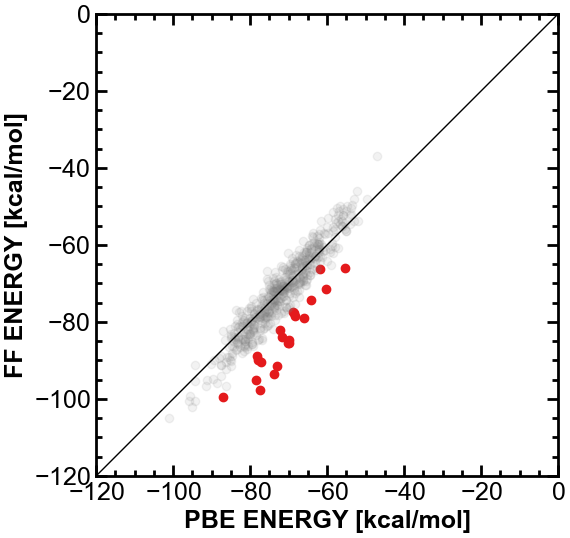

In [26]:
plt.scatter(ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"])
plt.scatter(ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.targets + ljpcff.data["ELEC"] , alpha=0.1, color="gray")

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")


In [27]:
# a,b,c = ljpcff.eval_jax([0.36058475, 1.74046017, 0.1, 0.1])
# a,b,c = ljpcff.eval_jax([ 0.1, 0.1, 0.36058475, 1.74046017,])

In [28]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.targets + ljpcff_test.data["ELEC"]
))

13.2972

In [29]:
np.sqrt(calc_rmse(
ffeval + ljpcff_test.data["ELEC"], ljpcff_test.data["intE"]
))

13.297200567445913

In [30]:
np.std((ffeval+ ljpcff_test.data["ELEC"]) - (ljpcff_test.targets+ ljpcff_test.data["ELEC"]))

3.81294

In [31]:
np.sqrt(calc_rmse(
ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"], ljpcff.data["intE"]
))

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


13.712412285996352

In [32]:
np.std((ljpcff.eval_best_parm().to_numpy().flatten() + ljpcff.data["ELEC"]) -  ljpcff.data["intE"])

Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters
HT HT
HT OT
OT OT


4.653626976057028

In [33]:
from scipy.optimize import minimize

In [34]:
LJ_bound

[(0.05, 4.0), (0.05, 4.0), (1e-05, 1.0), (1e-05, 1.0)]

In [35]:
ljpcff.get_best_parm()

array([0.33633235, 1.83830144, 0.00724429, 0.09999858])

In [177]:
minimize(ljpcff.get_loss_jax, ljpcff.get_best_parm(), method='TNC', 
         jac=ljpcff.get_loss_grad, 
         bounds=[(0.25,0.6), (0.25,2.0), (0.001, 0.15), (0.001, 0.15)],
         options={"maxfun":1000},
        )

# method=’L-BFGS-B’


 message: Converged (|f_n-f_(n-1)| ~= 0)
 success: True
  status: 1
     fun: 40.05537796020508
       x: [ 4.246e-01  1.620e+00  1.500e-01  1.500e-01]
     nit: 2
     jac: [ 3.006e-03  8.888e-02 -1.150e+01 -4.266e+01]
    nfev: 45

In [178]:
np.sqrt(42)

6.48074069840786

In [20]:
# OT     0.00  -0.1521  1.7682 ! ALLOW   WAT
# HT     0.00  -0.0460  0.2245 ! ALLOW WAT

In [36]:
# tip3
a,b,c = ljpcff.eval_jax([ 
        0.2245,
        1.7682, 
        0.0460, 
        0.1521, 
])
a,b,c = ljpcff_test.eval_jax(ljpcff.get_best_parm())

In [37]:
a

Array([35.165848, 45.76413 , 38.021008, 32.4792  , 24.692099, 32.84555 ,
       39.297874, 28.377382, 39.753353, 32.831837, 29.002554, 40.739933,
       33.108467, 39.20911 , 36.421307, 24.311417, 47.154926, 37.915607,
       28.320263, 42.97292 , 35.80004 ], dtype=float32)

In [38]:
a_,b_,c_ = ljpcff.eval_jax(ljpcff.get_best_parm())

In [39]:
# ljpcff.data

(array([ 26.,  74.,  92., 115.,  87.,  61.,  26.,  11.,   3.,   4.]),
 array([17.781696, 22.73928 , 27.696865, 32.65445 , 37.612034, 42.56962 ,
        47.5272  , 52.484783, 57.442368, 62.399952, 67.35754 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

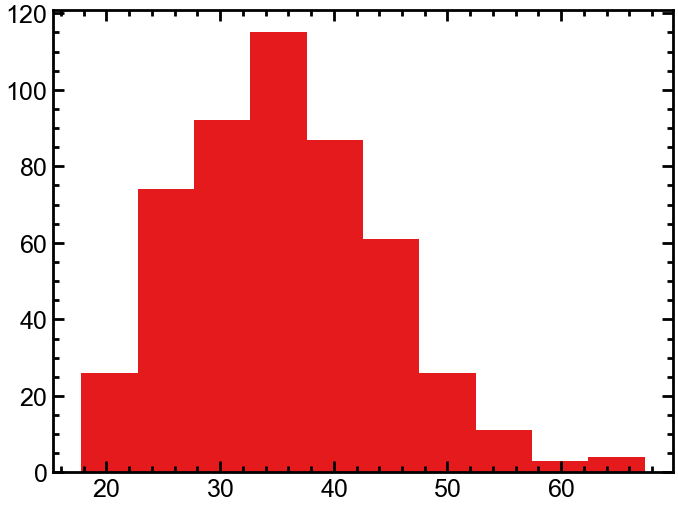

In [40]:
plt.hist(ljpcff.targets)

In [41]:
datacopy = ljpcff_test.data.copy()
datacopy["fitE"] = a
datacopy["target"] = ljpcff_test.targets
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target
KEY,,,,,,,,,,,,
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,35.165848,20.512978
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,45.764130,36.676460
test10,9.92008,-116.48635,24.00860,test10,-1527.187550,20,-1527.339045,-95.064088,-958409.833043,0.0,38.021008,21.422264
test11,10.09932,-110.00557,20.57407,test11,-1527.188313,20,-1527.344101,-97.757619,-958413.005378,0.0,32.479198,12.247948
test12,8.31472,-90.66729,13.68166,test12,-1527.189014,20,-1527.314804,-78.933784,-958394.621611,0.0,24.692099,11.733505
test13,10.85208,-104.60503,21.68685,test13,-1527.187075,20,-1527.320634,-83.808636,-958398.279715,0.0,32.845551,20.796394
test14,10.79645,-99.59153,24.96655,test14,-1527.189420,20,-1527.303115,-71.344336,-958387.286722,0.0,39.297874,28.247192
test15,9.39469,-100.67721,16.59224,test15,-1527.187259,20,-1527.318020,-82.052976,-958396.639655,0.0,28.377382,18.624229
test16,12.72297,-116.87092,25.73819,test16,-1527.184128,20,-1527.328125,-90.358079,-958402.980158,0.0,39.753353,26.512840


In [42]:
polE = [-13.711462635646853,
-13.113443990129525,
-12.595535442732256,
-14.095311000002027,
-7.846198418099789,
-12.72244261266701,
-15.185253636471117,
-10.552430608855872,
-16.05838886235921,
-13.43546129222463,
-16.157161381764638,
-14.957260399949945,
-12.250374787929417,
-12.388647565149626,
-12.296129425331827,
-11.34820265559486,
-13.58529778172462,
-10.313607651160595,
-13.382655931830868,
-15.163951361271273,]
datacopy = datacopy.loc[ ["test0",
"test1",
"test2",
"test3",
"test4",
"test5",
"test6",
"test7",
"test8",
"test9",
"test10",
"test11",
"test12",
"test13",
"test14",
"test15",
"test16",
"test17",
"test18",
"test19",]]
datacopy["EPOL"] = polE

In [43]:
datacopy

,TOTAL,ELEC,VDW,KEY,M_ENERGY,n_monomers,C_ENERGY,intE,C_ENERGY_kcalmol,DUMMY,fitE,target,EPOL
KEY,,,,,,,,,,,,,
test0,10.81688,-105.15090,22.08777,test0,-1527.187283,20,-1527.322163,-84.637925,-958399.239538,0.0,35.165848,20.512978,-13.711463
test1,10.61849,-114.41182,30.89695,test1,-1527.188251,20,-1527.312131,-77.735360,-958392.944428,0.0,45.764130,36.676460,-13.113444
test2,10.63913,-111.02871,21.05558,test2,-1527.187648,20,-1527.331104,-90.019409,-958404.850004,0.0,33.108467,21.009300,-12.595535
test3,10.50532,-109.56327,24.12367,test3,-1527.188524,20,-1527.334367,-91.516964,-958406.897045,0.0,36.421307,18.046310,-14.095311
test4,11.82599,-86.29590,13.29071,test4,-1527.183458,20,-1527.289190,-66.347298,-958378.548486,0.0,24.311417,19.948601,-7.846198
test5,10.79514,-125.32591,32.48558,test5,-1527.188095,20,-1527.329776,-88.904776,-958404.016178,0.0,47.154926,36.421135,-12.722443
test6,10.27872,-124.95550,24.40938,test6,-1527.186791,20,-1527.345572,-99.635761,-958413.928680,0.0,37.915607,25.319740,-15.185254
test7,11.01626,-92.40308,16.73097,test7,-1527.185562,20,-1527.304014,-74.328571,-958387.850459,0.0,28.320263,18.074516,-10.552431
test8,12.76158,-112.89762,28.75838,test8,-1527.185935,20,-1527.322128,-85.461648,-958399.217462,0.0,42.972919,27.435974,-16.058389


In [44]:
np.sqrt(calc_rmse(
    ljpcff.data.intE,
    a_ + ljpcff.data.ELECppol
))

3.3758459752675933

In [45]:
np.std(ljpcff.data.intE
    - (a_ + ljpcff.data.ELECppol))

3.3754788608820947

In [46]:
np.sqrt(calc_rmse(
datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
))

2.993997345260818

In [49]:
np.std(datacopy.intE -
    (datacopy.fitE + datacopy.ELEC + datacopy.EPOL))

2.988065044573004

In [47]:
# np.sqrt(calc_rmse(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC))

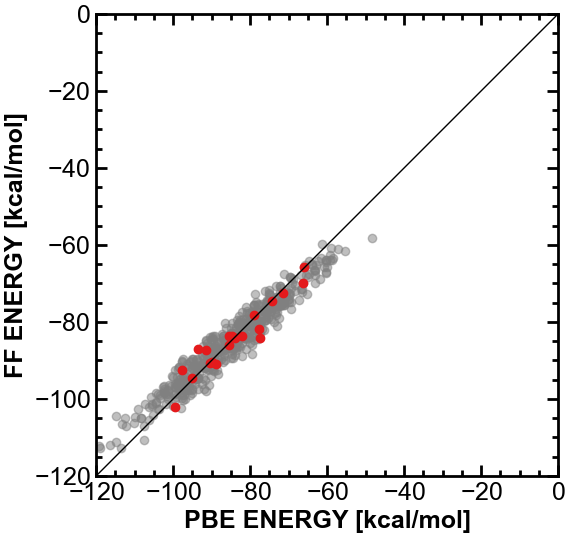

In [48]:
plt.scatter(
            ljpcff.data.intE,
            a_ + ljpcff.data.ELECppol,  c="gray", alpha=0.5)
plt.scatter(datacopy.intE, datacopy.fitE + datacopy.ELEC + datacopy.EPOL)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_test.png")

In [199]:
datacopy.ELEC + datacopy.EPOL

KEY
test0     -90.185183
test1     -98.831144
test2     -98.630625
test3     -97.445361
test4     -68.935968
test5    -100.369313
test6    -108.324734
test7     -75.931151
test8    -101.815509
test9     -92.246431
test10   -105.932221
test11    -94.888240
test12    -80.167325
test13    -91.430018
test14    -83.876379
test15    -83.656513
test16   -100.168548
test17    -72.367368
test18    -91.562326
test19    -95.744461
dtype: float64

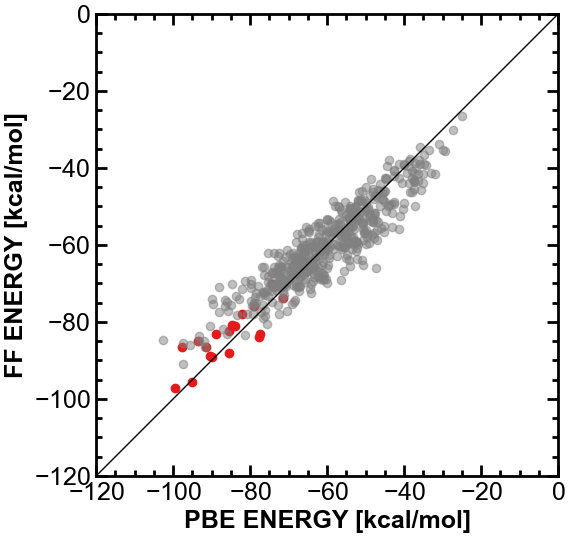

In [200]:
plt.scatter(datacopy.intE,
    datacopy.fitE + datacopy.ELEC + datacopy.EPOL
            )
plt.scatter(FFOBJ.data.intE, a_ + FFOBJ.data.ELEC, c="gray", alpha=0.5)

plt.plot([-120, 0], [-120, 0], c="k")

plt.xlim(-120, 0)
plt.ylim(-120, 0)
plt.gca().set_aspect('equal')

plt.xlabel("PBE ENERGY [kcal/mol]")
plt.ylabel("FF ENERGY [kcal/mol]")
plt.savefig("water_pc_pol_test.png")